**Regression of Used Car Prices**


Анализ фичей:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import gc

In [2]:
df_sub=pd.read_csv("data/sample_submission.csv")
df_train=pd.read_csv("data/train.csv")
df_test=pd.read_csv("data/test.csv")

In [3]:
df_train.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [4]:
df_test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes


In [5]:
df_test.shape,df_train.shape

((125690, 12), (188533, 13))

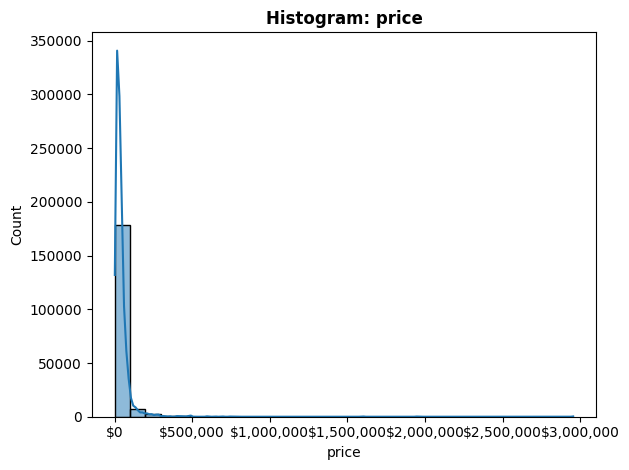

In [6]:
col = 'price'
ax = plt.gca()

sns.histplot(df_train[col], bins=30, kde=True, ax=ax)

ax.set_title(f"Histogram: {col}", fontsize=12, fontweight='bold')
ax.set_xlabel(col, fontsize=10)
ax.set_ylabel("Count", fontsize=10)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

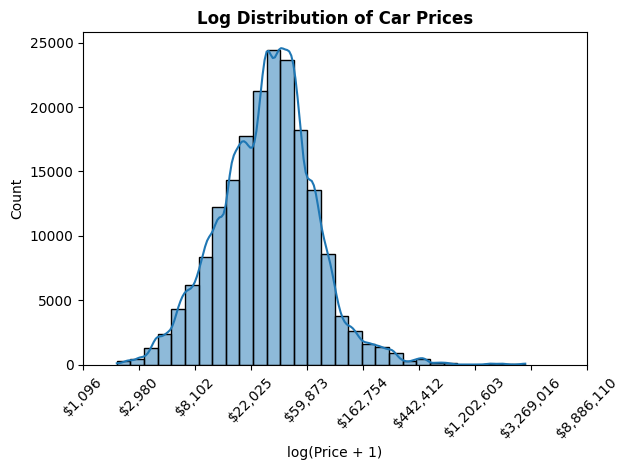

In [7]:
import numpy as np

col = 'price'
ax = plt.gca() 

sns.histplot(np.log1p(df_train[col]), bins=30, kde=True, ax=ax)

ax.set_title(f"Log Distribution of Car Prices", fontsize=12, fontweight='bold')
ax.set_xlabel("log(Price + 1)", fontsize=10)
ax.set_ylabel("Count", fontsize=10)

ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f'${np.exp(tick)-1:,.0f}' for tick in ticks], rotation=45)

plt.tight_layout()
plt.show()

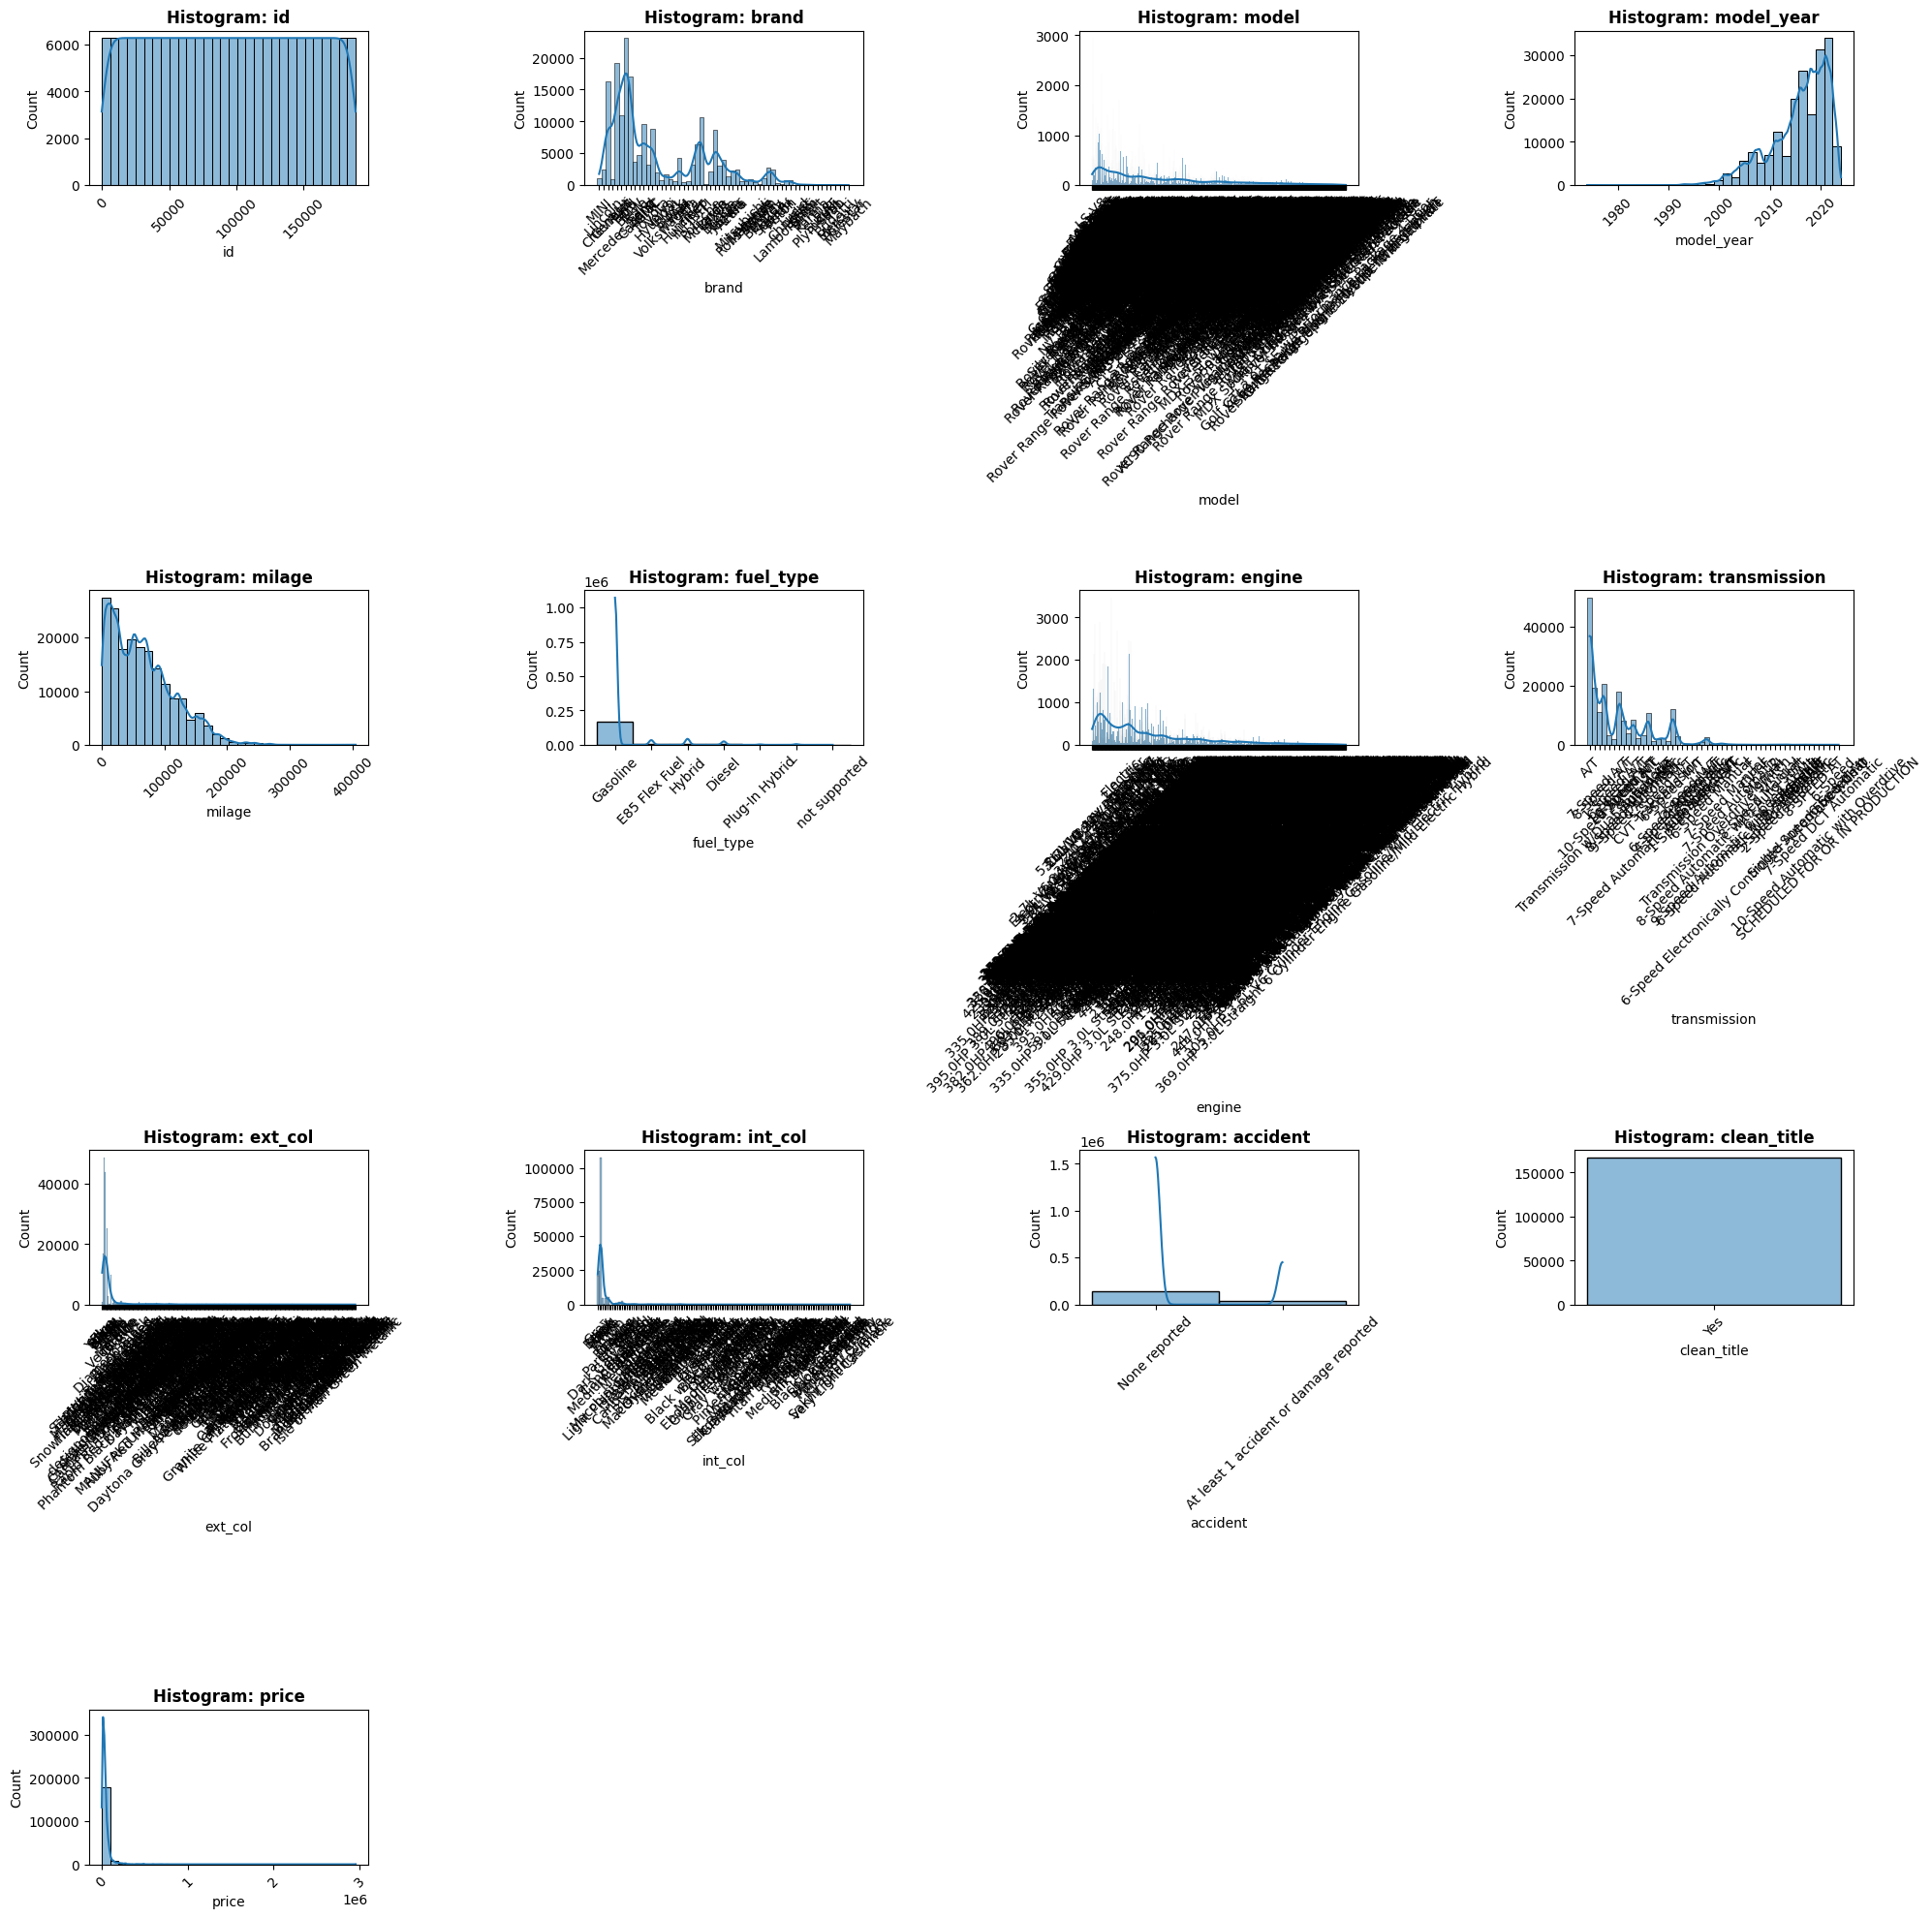

In [8]:
import math
n_cols = len(df_train.columns)
n_rows = math.ceil(n_cols / 4)

fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5 * n_rows))
axes = axes.flatten() 

for i in range(n_cols, len(axes)):
    axes[i].set_visible(False)

for idx, col in enumerate(df_train.columns):
    ax = axes[idx]
    
    sns.histplot(df_train[col], bins=30, kde=True, ax=ax)
    
    ax.set_title(f"Histogram: {col}", fontsize=12, fontweight='bold')
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Count", fontsize=10)
    
    if len(df_train[col].unique()) > 10 or df_train[col].dtype == 'object':
        ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [9]:
df_train = df_train.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

In [10]:
df_train.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [11]:
df_test.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64

In [12]:
df_train.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [13]:
df_train['price']

0          4200
1          4999
2         13900
3         45000
4         97500
          ...  
188528    27500
188529    30000
188530    86900
188531    84900
188532    28995
Name: price, Length: 188533, dtype: int64

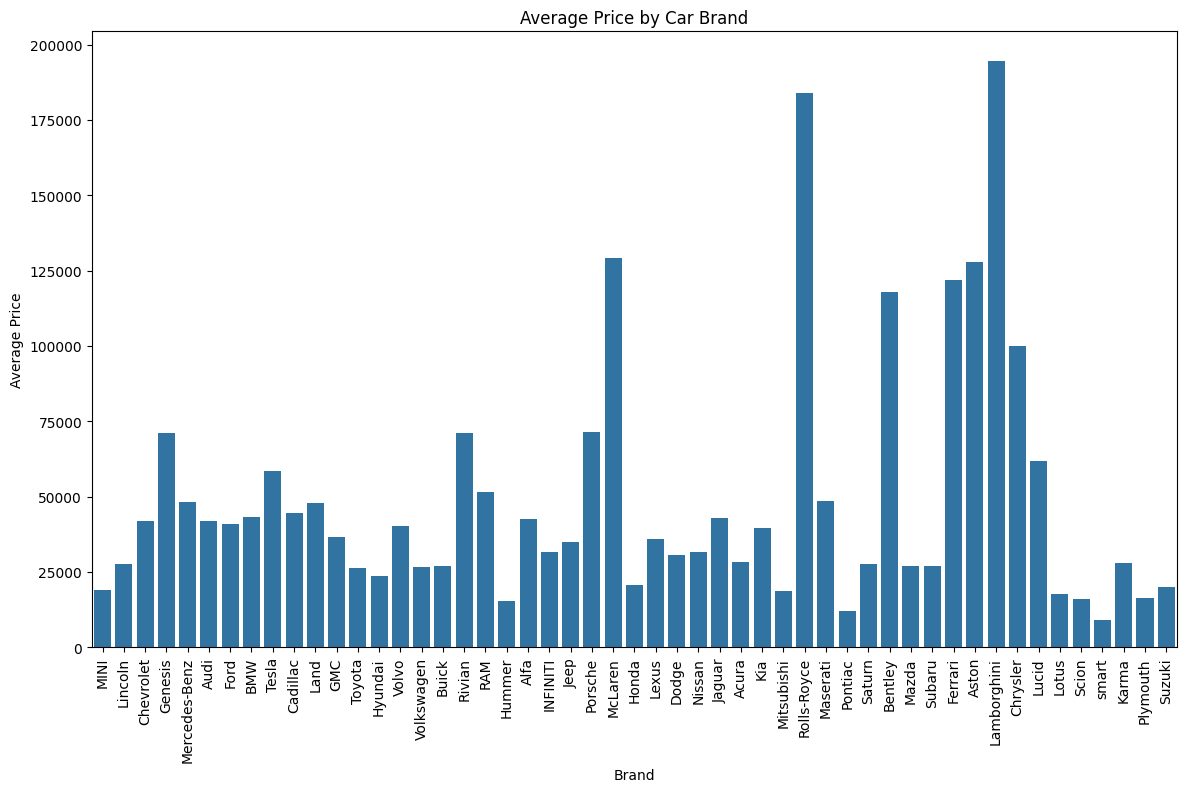

In [14]:
plt.figure(figsize=(14, 8))
sns.barplot(x='brand', y='price', data=df_train[:10000], errorbar=None)
plt.title('Average Price by Car Brand')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.xticks(rotation=90)  
plt.show()

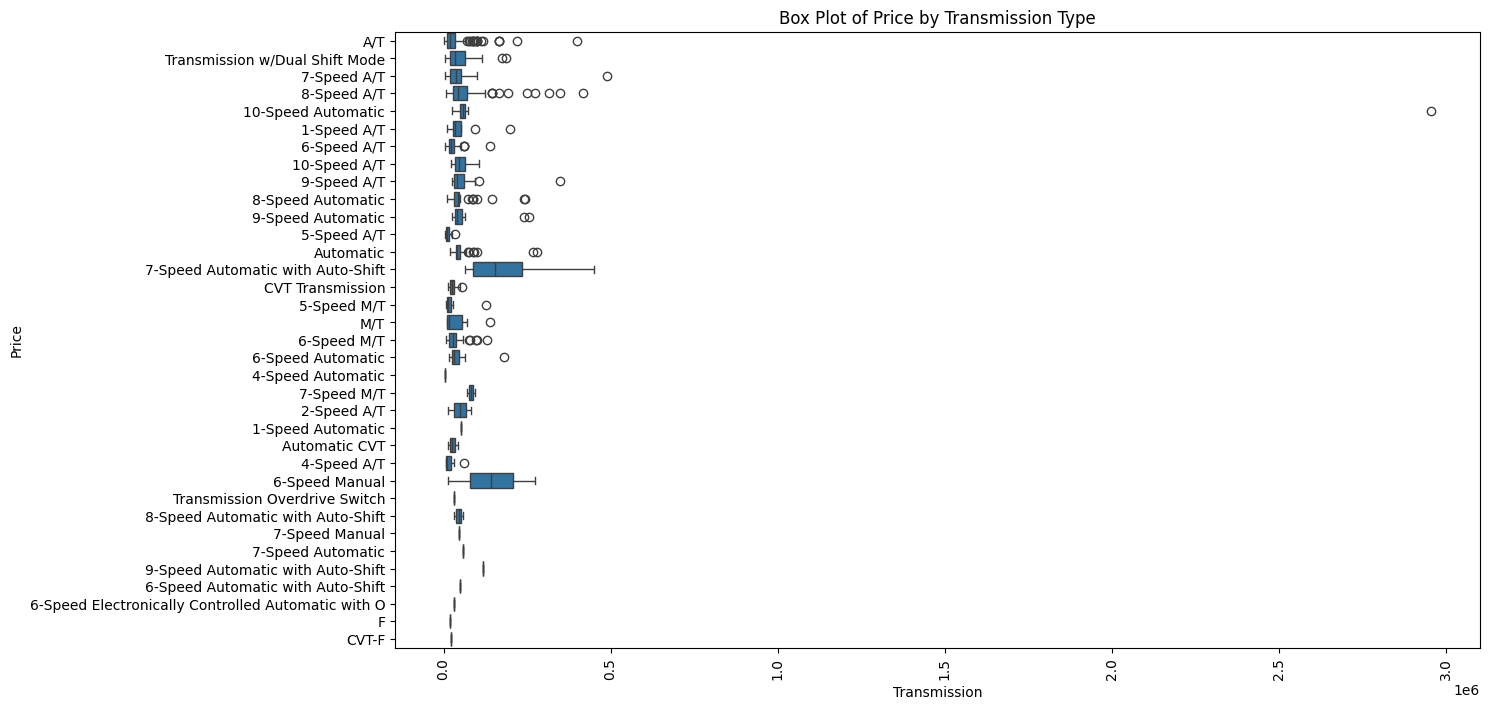

In [15]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='price', y='transmission', data=df_train[:1000],orient='h')
plt.title('Box Plot of Price by Transmission Type')
plt.xlabel('Transmission')
plt.ylabel('Price')
plt.xticks(rotation=90) 
plt.show()

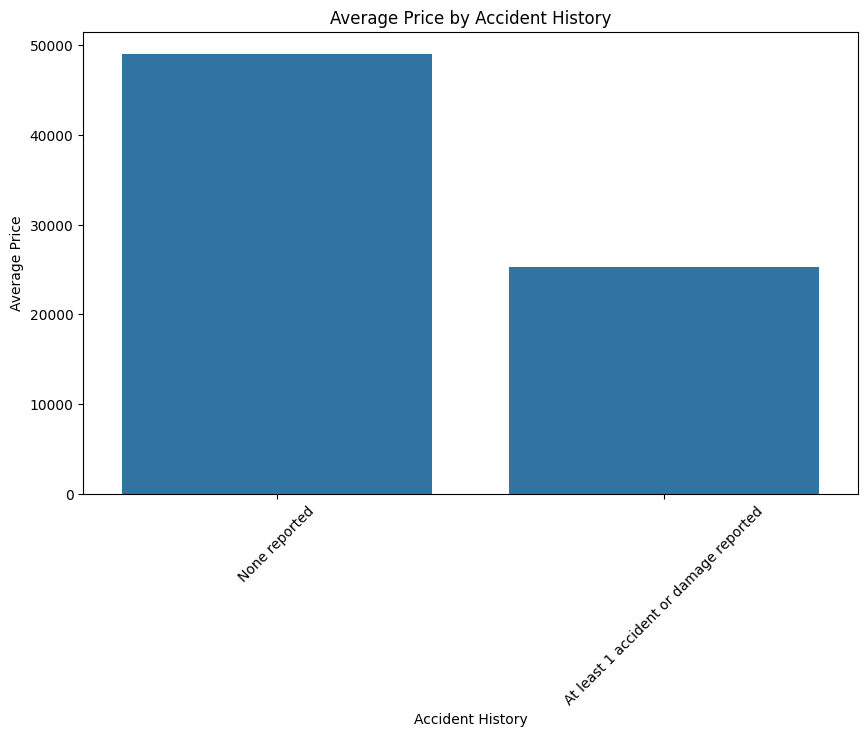

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x='accident', y='price', data=df_train, errorbar=None)
plt.title('Average Price by Accident History')
plt.xlabel('Accident History')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

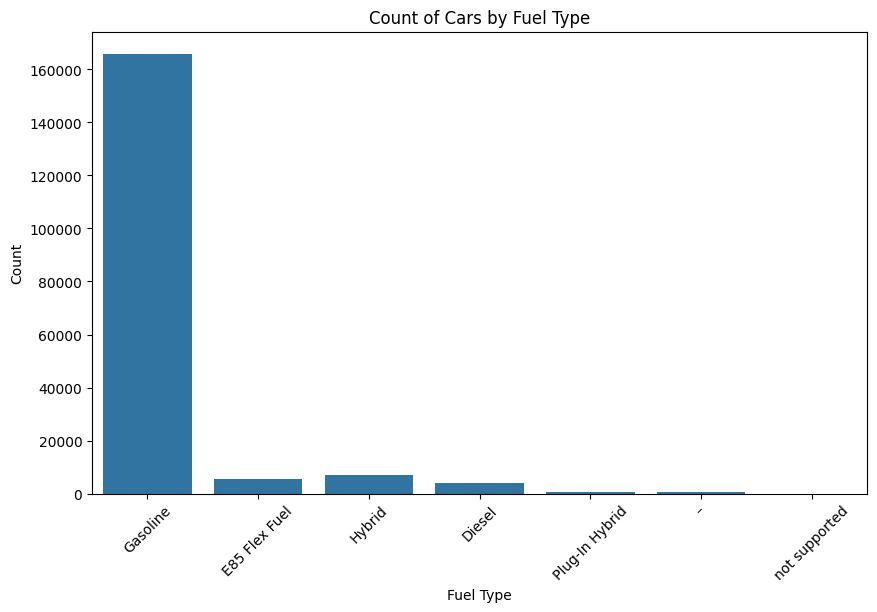

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(x='fuel_type', data=df_train)
plt.title('Count of Cars by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

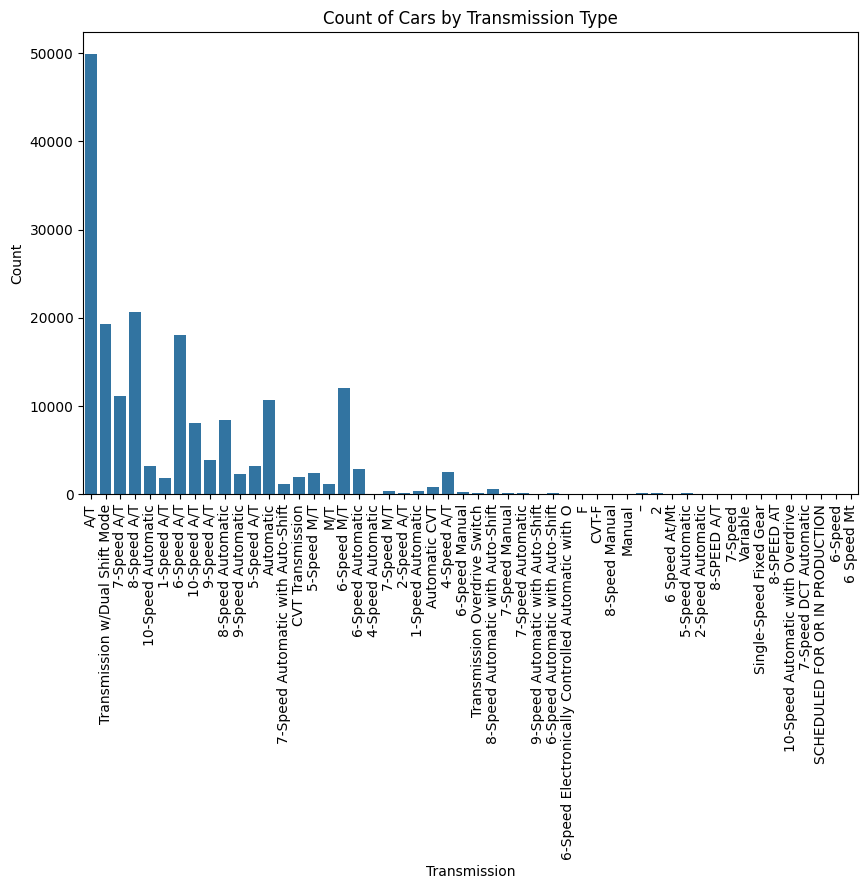

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(x='transmission', data=df_train)
plt.title('Count of Cars by Transmission Type')
plt.xlabel('Transmission')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [19]:
categorical_columns = df_train.select_dtypes(include=['object']).columns
unique_values = {col: df_train[col].nunique() for col in categorical_columns}
for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")
    
gc.collect()

brand: 57 unique values
model: 1897 unique values
fuel_type: 7 unique values
engine: 1117 unique values
transmission: 52 unique values
ext_col: 319 unique values
int_col: 156 unique values
accident: 2 unique values
clean_title: 1 unique values


2943

In [20]:
categorical_columns = df_test.select_dtypes(include=['object']).columns
unique_values = {col: df_test[col].nunique() for col in categorical_columns}
for col, unique_count in unique_values.items():
    print(f"{col}: {unique_count} unique values")
    
gc.collect()

brand: 55 unique values
model: 1891 unique values
fuel_type: 7 unique values
engine: 1117 unique values
transmission: 52 unique values
ext_col: 317 unique values
int_col: 156 unique values
accident: 2 unique values
clean_title: 1 unique values


44840

In [21]:
df_test.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'],
      dtype='object')

In [22]:
df_train.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [23]:
import seaborn as sns

In [24]:
missing_train = df_train.isna().mean() * 100
missing_test = df_test.isna().mean() * 100

print("Columns in df_train with more than 10% missing values:")
print(missing_train[missing_train > 0])

print("\nColumns in df_test with more than 10% missing values:")
print(missing_test[missing_test > 0])

Columns in df_train with more than 10% missing values:
fuel_type       2.696080
accident        1.300568
clean_title    11.360876
dtype: float64

Columns in df_test with more than 10% missing values:
fuel_type       2.691543
accident        1.298433
clean_title    11.328666
dtype: float64


/tmp/ipykernel_437245/3726948150.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')


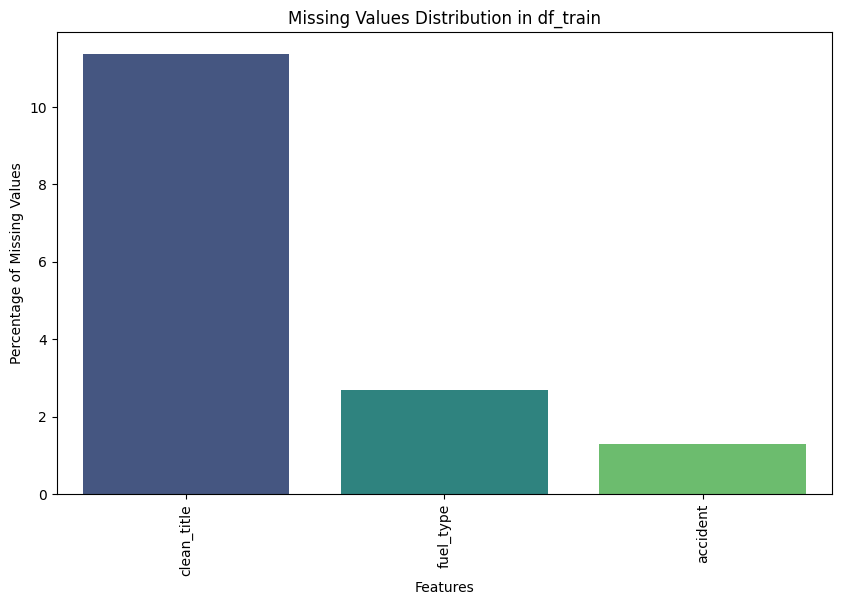

In [25]:
missing_values = df_train.isnull().mean() * 100
missing_values = missing_values[missing_values >0]
missing_values = missing_values.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')
plt.title('Missing Values Distribution in df_train')
plt.show()

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import category_encoders as ce

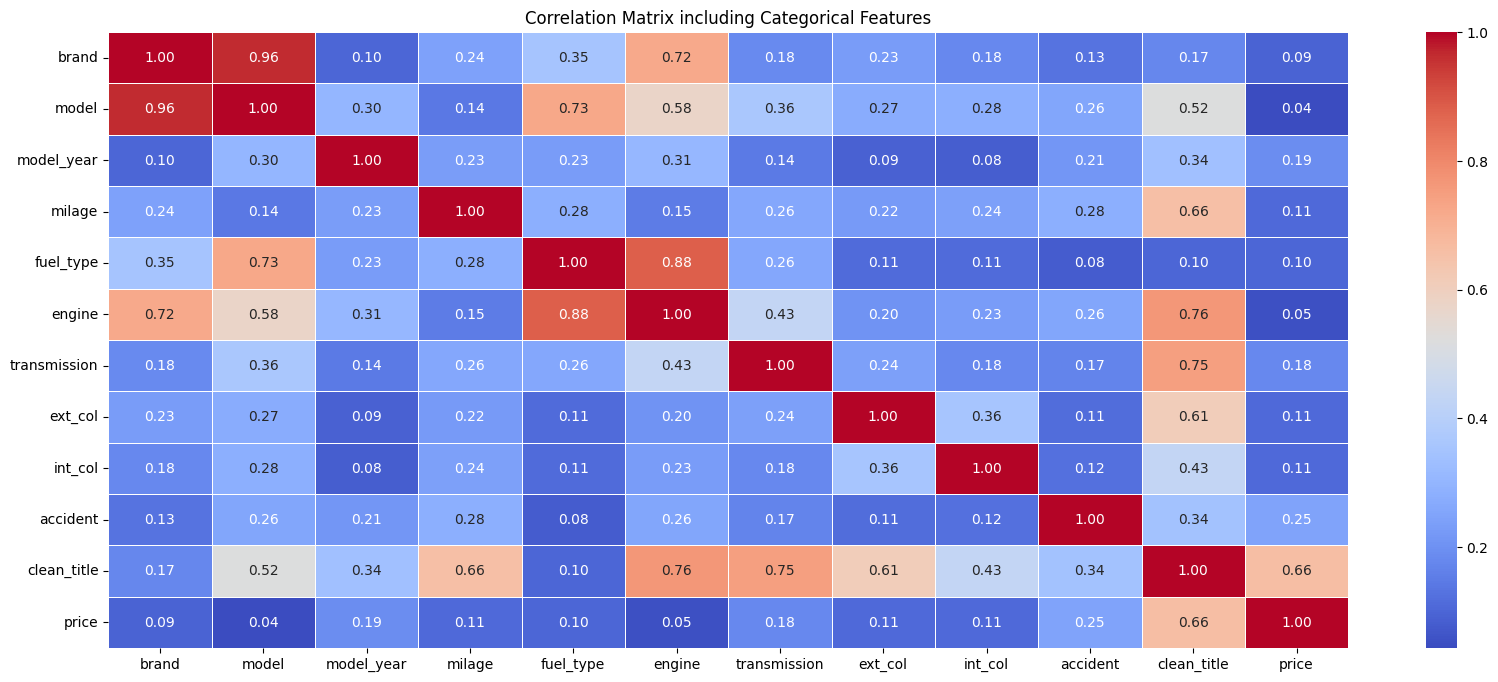

In [27]:
from dython.nominal import associations

associations_df = associations(df_train, nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

In [28]:
df_train.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [29]:
from sklearn.impute import KNNImputer
import pandas as pd

def knn_impute(df, n_neighbors=5):
    """
    Заполняет пропуски с помощью KNN, сохраняя категориальные значения.
    
    Args:
        df: DataFrame с пропусками
        n_neighbors: количество соседей для KNN
        
    Returns:
        DataFrame без пропусков
    """
    df_copy = df.copy()
    cat_cols = df_copy.select_dtypes(include='object').columns.tolist()
    
    if len(cat_cols) > 0:
        cat_mappings = {}
        for col in cat_cols:
            df_copy[col] = df_copy[col].astype('category')
            cat_mappings[col] = dict(enumerate(df_copy[col].cat.categories))
            df_copy[col] = df_copy[col].cat.codes
    
        df_copy[cat_cols] = df_copy[cat_cols].replace(-1, np.nan)
    
    imputer = KNNImputer(n_neighbors=n_neighbors)
    df_imputed = pd.DataFrame(
        imputer.fit_transform(df_copy),
        columns=df_copy.columns,
        index=df_copy.index
    )
    
    if len(cat_cols) > 0:
        for col in cat_cols:
            df_imputed[col] = df_imputed[col].round().astype(int)
            df_imputed[col] = df_imputed[col].map(cat_mappings[col])
    
    return df_imputed

In [30]:
df_train_imputed = knn_impute(df_train, n_neighbors=25)
df_test_imputed = knn_impute(df_test, n_neighbors=25)

In [31]:
from sklearn.preprocessing import OrdinalEncoder
cat_cols_train = df_train_imputed.select_dtypes(include=['object']).columns
cat_cols_train = cat_cols_train[cat_cols_train != 'class']
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

df_train_imputed[cat_cols_train] = ordinal_encoder.fit_transform(df_train_imputed[cat_cols_train].astype(str))
df_test_imputed[cat_cols_train] = ordinal_encoder.transform(df_test_imputed[cat_cols_train].astype(str))

In [32]:
df_train_imputed.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,31.0,495.0,2007.0,213000.0,2.0,116.0,38.0,312.0,71.0,1.0,0.0,4200.0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,0.0,4999.0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,0.0,13900.0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,0.0,45000.0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,0.0,97500.0


In [33]:
df_test_imputed.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,26.0,1390.0,2015.0,98000.0,2.0,325.0,16.0,304.0,10.0,1.0,0.0
1,26.0,1377.0,2020.0,9142.0,3.0,787.0,31.0,263.0,14.0,1.0,0.0
2,14.0,636.0,2022.0,28121.0,2.0,540.0,3.0,304.0,57.0,1.0,0.0
3,3.0,182.0,2016.0,61258.0,2.0,192.0,39.0,261.0,14.0,1.0,0.0
4,3.0,181.0,2018.0,59000.0,2.0,364.0,38.0,128.0,14.0,1.0,0.0


In [34]:
df_train = df_train_imputed
df_test = df_test_imputed

In [35]:
df_train['engine_transmission'] = df_train['engine'] * df_train['transmission']
df_test['engine_transmission'] = df_test['engine'] * df_test['transmission']

In [36]:
df_train.isnull().sum()

brand                  0
model                  0
model_year             0
milage                 0
fuel_type              0
engine                 0
transmission           0
ext_col                0
int_col                0
accident               0
clean_title            0
price                  0
engine_transmission    0
dtype: int64

In [37]:
current_year = 2025
luxury_brands = ['Mercedes-Benz', 'BMW', 'Audi', 'Lexus', 'Tesla']


def create_features(df):
    df['vehicle_age'] = current_year - df['model_year']  
    df['vehicle_age_int'] = df['vehicle_age'].astype(int)
    df['mileage_per_year'] = df['milage'] / df['vehicle_age']
    df['mileage_per_year'].replace([np.inf, -np.inf], 0, inplace=True)   
    df['rare_fuel_type'] = df['fuel_type'].apply(lambda x: 0 if x in ['Petrol', 'Diesel'] else 1)
    df['is_automatic'] = df['transmission'].apply(lambda x: 1 if x == 'Automatic' else 0)
    df['has_accident_history'] = df['accident'].apply(lambda x: 1 if x != 'Unknown' and x != 'None' else 0)
    df['engine_power_category'] = pd.qcut(df['engine'], q=3, labels=['Low', 'Medium', 'High'])
    df['color_match'] = df.apply(lambda row: 1 if row['ext_col'] == row['int_col'] else 0, axis=1)
    df['is_luxury_brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)
    return df
df_train = create_features(df_train)
df_test = create_features(df_test)

/tmp/ipykernel_437245/1078608718.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['mileage_per_year'].replace([np.inf, -np.inf], 0, inplace=True)
/tmp/ipykernel_437245/1078608718.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value

In [38]:
df_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,engine_transmission,vehicle_age,vehicle_age_int,mileage_per_year,rare_fuel_type,is_automatic,has_accident_history,engine_power_category,color_match,is_luxury_brand
0,31.0,495.0,2007.0,213000.0,2.0,116.0,38.0,312.0,71.0,1.0,...,4408.0,18.0,18,11833.333333,1,0,1,Low,0,0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,...,13908.0,23.0,23,6228.260870,1,0,1,Low,0,0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,...,24320.0,23.0,23,5944.826087,1,0,1,Medium,0,0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,...,42287.0,8.0,8,2437.500000,1,0,1,High,0,0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,...,5957.0,4.0,4,1847.000000,1,0,1,Low,0,0


In [39]:
df_test.shape,df_train.shape

((125690, 21), (188533, 22))

In [40]:
df_train

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,engine_transmission,vehicle_age,vehicle_age_int,mileage_per_year,rare_fuel_type,is_automatic,has_accident_history,engine_power_category,color_match,is_luxury_brand
0,31.0,495.0,2007.0,213000.0,2.0,116.0,38.0,312.0,71.0,1.0,...,4408.0,18.0,18,11833.333333,1,0,1,Low,0,0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,...,13908.0,23.0,23,6228.260870,1,0,1,Low,0,0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,...,24320.0,23.0,23,5944.826087,1,0,1,Medium,0,0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,...,42287.0,8.0,8,2437.500000,1,0,1,High,0,0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,...,5957.0,4.0,4,1847.000000,1,0,1,Low,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,8.0,604.0,2017.0,49000.0,2.0,866.0,49.0,304.0,10.0,1.0,...,42434.0,8.0,8,6125.000000,1,0,1,High,0,0
188529,36.0,206.0,2018.0,28600.0,2.0,770.0,31.0,304.0,14.0,0.0,...,23870.0,7.0,7,4085.714286,1,0,1,Medium,0,0
188530,36.0,223.0,2021.0,13650.0,2.0,921.0,23.0,304.0,14.0,1.0,...,21183.0,4.0,4,3412.500000,1,0,1,High,0,0
188531,3.0,1471.0,2022.0,13895.0,2.0,512.0,1.0,82.0,14.0,1.0,...,512.0,3.0,3,4631.666667,1,0,1,Medium,0,0


In [41]:
df_test.shape,df_train.shape

((125690, 21), (188533, 22))

In [42]:
def remove_outliers_iqr(df, columns, multiplier=1.5):
    """
    Удаляет выбросы по методу IQR для одного или нескольких столбцов.
    
    Args:
        df: DataFrame
        columns: str или list - имя столбца или список столбцов
        multiplier: множитель для IQR (по умолчанию 1.5)
    
    Returns:
        DataFrame без выбросов
    """
    df_filtered = df.copy()
    if isinstance(columns, str):
        columns = [columns]
    
    for column in columns:
        if column not in df_filtered.columns:
            print(f"Предупреждение: колонка '{column}' не найдена")
            continue
            
        Q1 = df_filtered[column].quantile(0.25)
        Q3 = df_filtered[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        mask = (df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)
        df_filtered = df_filtered[mask].copy()
        
        print(f"Удалено выбросов из '{column}': {len(df) - len(df_filtered)}")
    
    return df_filtered.reset_index(drop=True)

df_train_no_outliers = remove_outliers_iqr(df_train, ['milage', 'price'])

Удалено выбросов из 'milage': 1766
Удалено выбросов из 'price': 12633


In [43]:
df_train

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,engine_transmission,vehicle_age,vehicle_age_int,mileage_per_year,rare_fuel_type,is_automatic,has_accident_history,engine_power_category,color_match,is_luxury_brand
0,31.0,495.0,2007.0,213000.0,2.0,116.0,38.0,312.0,71.0,1.0,...,4408.0,18.0,18,11833.333333,1,0,1,Low,0,0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,...,13908.0,23.0,23,6228.260870,1,0,1,Low,0,0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,...,24320.0,23.0,23,5944.826087,1,0,1,Medium,0,0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,...,42287.0,8.0,8,2437.500000,1,0,1,High,0,0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,...,5957.0,4.0,4,1847.000000,1,0,1,Low,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188528,8.0,604.0,2017.0,49000.0,2.0,866.0,49.0,304.0,10.0,1.0,...,42434.0,8.0,8,6125.000000,1,0,1,High,0,0
188529,36.0,206.0,2018.0,28600.0,2.0,770.0,31.0,304.0,14.0,0.0,...,23870.0,7.0,7,4085.714286,1,0,1,Medium,0,0
188530,36.0,223.0,2021.0,13650.0,2.0,921.0,23.0,304.0,14.0,1.0,...,21183.0,4.0,4,3412.500000,1,0,1,High,0,0
188531,3.0,1471.0,2022.0,13895.0,2.0,512.0,1.0,82.0,14.0,1.0,...,512.0,3.0,3,4631.666667,1,0,1,Medium,0,0


In [44]:
df_train_no_outliers.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,engine_transmission,vehicle_age,vehicle_age_int,mileage_per_year,rare_fuel_type,is_automatic,has_accident_history,engine_power_category,color_match,is_luxury_brand
0,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,...,13908.0,23.0,23,6228.260870,1,0,1,Low,0,0
1,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,...,24320.0,23.0,23,5944.826087,1,0,1,Medium,0,0
2,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,...,42287.0,8.0,8,2437.500000,1,0,1,High,0,0
3,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,...,5957.0,4.0,4,1847.000000,1,0,1,Low,0,0
4,3.0,182.0,2018.0,40950.0,2.0,364.0,38.0,304.0,155.0,1.0,...,13832.0,7.0,7,5850.000000,1,0,1,Low,0,0


In [45]:
df_train_no_outliers.isnull().sum()

brand                    0
model                    0
model_year               0
milage                   0
fuel_type                0
engine                   0
transmission             0
ext_col                  0
int_col                  0
accident                 0
clean_title              0
price                    0
engine_transmission      0
vehicle_age              0
vehicle_age_int          0
mileage_per_year         0
rare_fuel_type           0
is_automatic             0
has_accident_history     0
engine_power_category    0
color_match              0
is_luxury_brand          0
dtype: int64

In [46]:
df_train_no_outliers.isnull().sum()

brand                    0
model                    0
model_year               0
milage                   0
fuel_type                0
engine                   0
transmission             0
ext_col                  0
int_col                  0
accident                 0
clean_title              0
price                    0
engine_transmission      0
vehicle_age              0
vehicle_age_int          0
mileage_per_year         0
rare_fuel_type           0
is_automatic             0
has_accident_history     0
engine_power_category    0
color_match              0
is_luxury_brand          0
dtype: int64

In [47]:
df_train_no_outliers.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,engine_transmission,vehicle_age,vehicle_age_int,mileage_per_year,rare_fuel_type,is_automatic,has_accident_history,engine_power_category,color_match,is_luxury_brand
0,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,...,13908.0,23.0,23,6228.260870,1,0,1,Low,0,0
1,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,...,24320.0,23.0,23,5944.826087,1,0,1,Medium,0,0
2,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,...,42287.0,8.0,8,2437.500000,1,0,1,High,0,0
3,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,...,5957.0,4.0,4,1847.000000,1,0,1,Low,0,0
4,3.0,182.0,2018.0,40950.0,2.0,364.0,38.0,304.0,155.0,1.0,...,13832.0,7.0,7,5850.000000,1,0,1,Low,0,0


/tmp/ipykernel_437245/2435632018.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x='fuel_type', y='price', data=df_train_no_outliers,
/tmp/ipykernel_437245/2435632018.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='fuel_type', y='price', data=df_train_no_outliers,
/tmp/ipykernel_437245/2435632018.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stats.index, y=stats['count'], ax=ax2, palette='Blues')


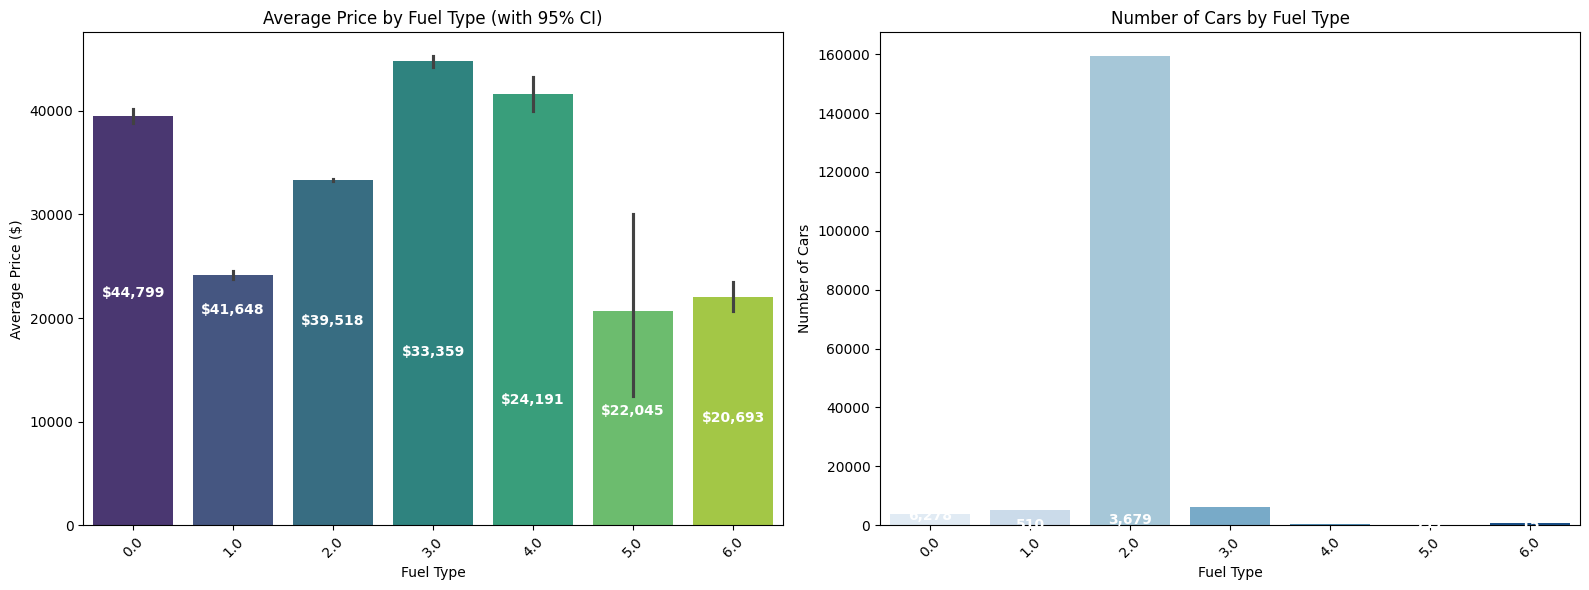


 Статистика цен по типам топлива:
               mean   median       std   count
fuel_type                                     
3.0        44798.83  42598.0  21579.26    6278
4.0        41648.44  38247.5  19658.27     510
0.0        39517.85  37300.0  22302.67    3679
2.0        33358.68  29000.0  21316.07  159448
1.0        24190.70  19900.0  15201.08    5253
6.0        22045.33  15995.0  18830.41     717
5.0        20692.73  14000.0  17726.39      15


In [48]:
stats = df_train_no_outliers.groupby('fuel_type')['price'].agg([
    'mean', 'median', 'std', 'count'
]).round(2).sort_values('mean', ascending=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x='fuel_type', y='price', data=df_train_no_outliers, 
            ci=95, ax=ax1, palette='viridis')
ax1.set_title('Average Price by Fuel Type (with 95% CI)')
ax1.set_xlabel('Fuel Type')
ax1.set_ylabel('Average Price ($)')
ax1.tick_params(axis='x', rotation=45)

for i, (idx, row) in enumerate(stats.iterrows()):
    ax1.text(i, row['mean']/2, f'${row["mean"]:,.0f}', 
             ha='center', va='center', color='white', fontweight='bold')

sns.barplot(x=stats.index, y=stats['count'], ax=ax2, palette='Blues')
ax2.set_title('Number of Cars by Fuel Type')
ax2.set_xlabel('Fuel Type')
ax2.set_ylabel('Number of Cars')
ax2.tick_params(axis='x', rotation=45)

for i, count in enumerate(stats['count']):
    ax2.text(i, count/2, f'{count:,}', 
             ha='center', va='center', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Статистика цен по типам топлива:")
print(stats)

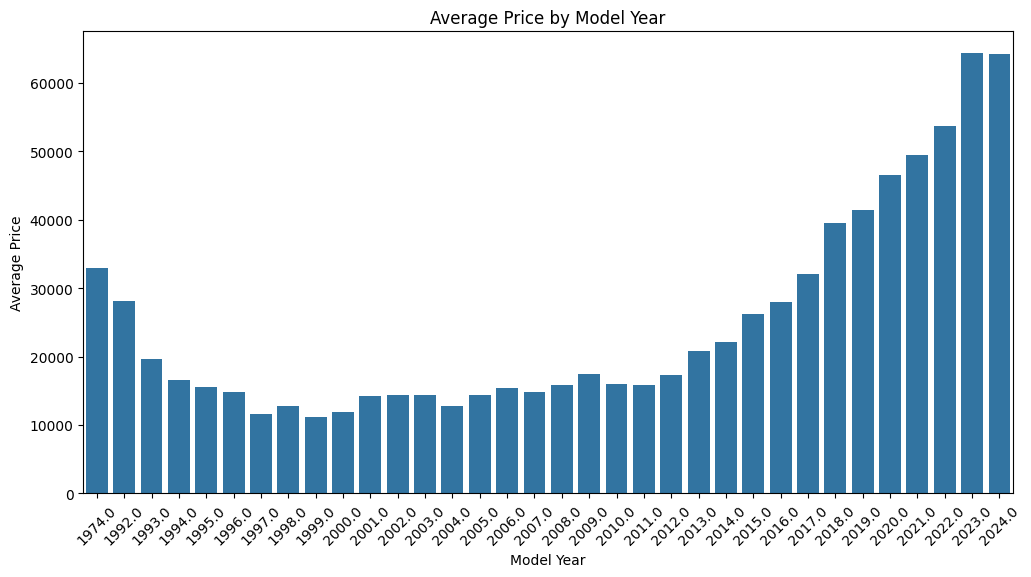

In [49]:
plt.figure(figsize=(12, 6))
sns.barplot(x='model_year', y='price', data=df_train_no_outliers, errorbar=None)
plt.title('Average Price by Model Year')
plt.xlabel('Model Year')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

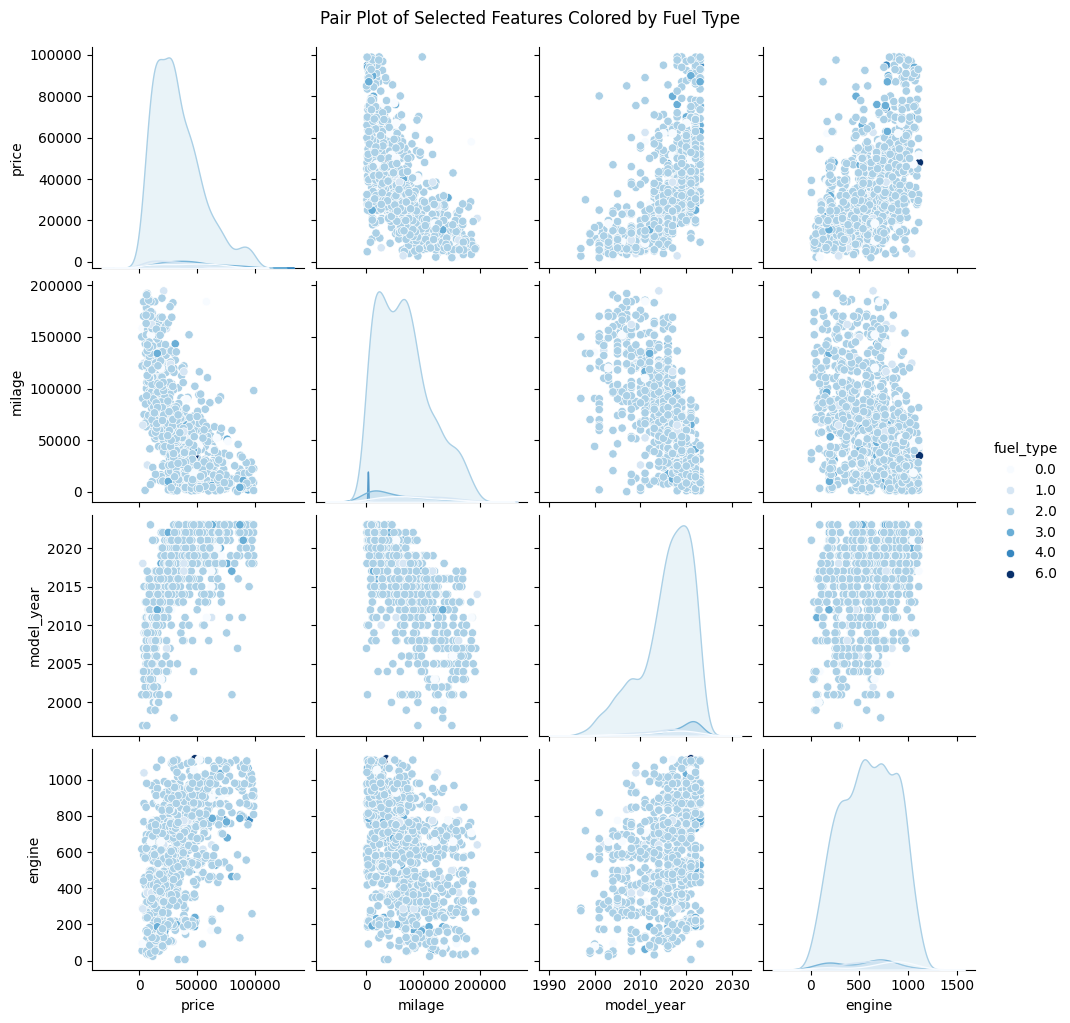

In [50]:
x = df_train_no_outliers[:1000]
sns.pairplot(x[['price', 'milage', 'model_year', 'engine', 'fuel_type']], hue='fuel_type', palette='Blues')
plt.suptitle('Pair Plot of Selected Features Colored by Fuel Type', y=1.02)
plt.show()

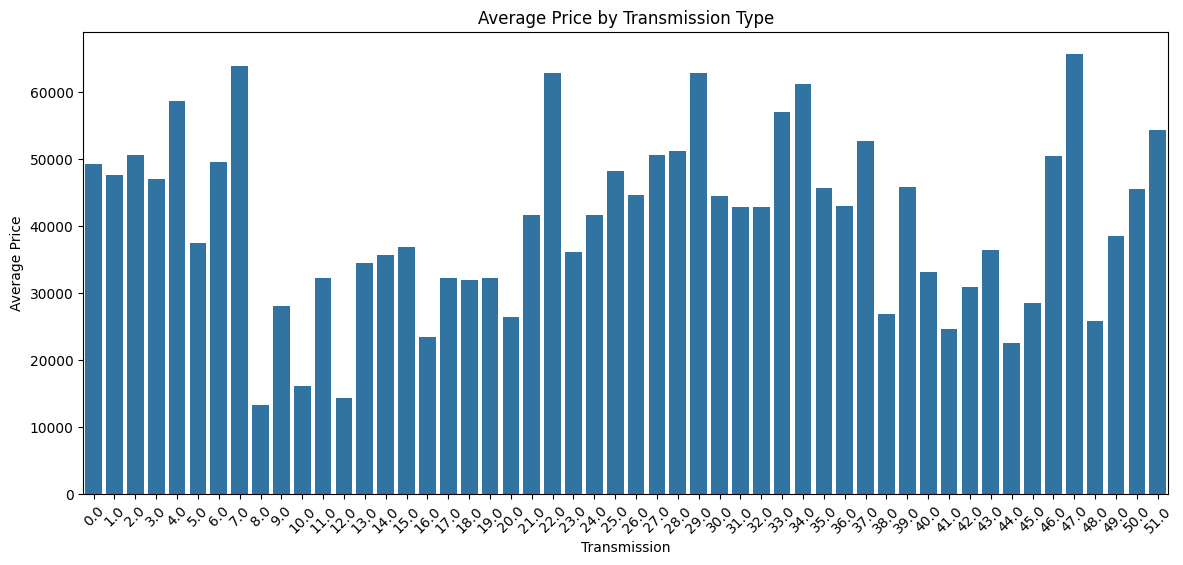

In [51]:
plt.figure(figsize=(14, 6))
sns.barplot(x='transmission', y='price', data=df_train_no_outliers, errorbar=None)
plt.title('Average Price by Transmission Type')
plt.xlabel('Transmission')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

In [52]:
y = df_train['price'] 
X = df_train.drop(['price'],axis=1)

In [53]:
df_train.shape

(188533, 22)

In [54]:
df_train.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price', 'engine_transmission', 'vehicle_age', 'vehicle_age_int',
       'mileage_per_year', 'rare_fuel_type', 'is_automatic',
       'has_accident_history', 'engine_power_category', 'color_match',
       'is_luxury_brand'],
      dtype='object')

In [55]:
df_test.shape

(125690, 21)

In [56]:
df_test.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'engine_transmission', 'vehicle_age', 'vehicle_age_int',
       'mileage_per_year', 'rare_fuel_type', 'is_automatic',
       'has_accident_history', 'engine_power_category', 'color_match',
       'is_luxury_brand'],
      dtype='object')

In [57]:
df_train.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,engine_transmission,vehicle_age,vehicle_age_int,mileage_per_year,rare_fuel_type,is_automatic,has_accident_history,engine_power_category,color_match,is_luxury_brand
0,31.0,495.0,2007.0,213000.0,2.0,116.0,38.0,312.0,71.0,1.0,...,4408.0,18.0,18,11833.333333,1,0,1,Low,0,0
1,28.0,930.0,2002.0,143250.0,2.0,366.0,38.0,263.0,10.0,0.0,...,13908.0,23.0,23,6228.260870,1,0,1,Low,0,0
2,9.0,1575.0,2002.0,136731.0,1.0,640.0,38.0,38.0,71.0,1.0,...,24320.0,23.0,23,5944.826087,1,0,1,Medium,0,0
3,16.0,758.0,2017.0,19500.0,2.0,863.0,49.0,29.0,14.0,1.0,...,42287.0,8.0,8,2437.500000,1,0,1,High,0,0
4,36.0,1077.0,2021.0,7388.0,2.0,259.0,23.0,29.0,10.0,1.0,...,5957.0,4.0,4,1847.000000,1,0,1,Low,0,0


In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

X_encoded = X.copy()
df_test_encoded = df_test.copy()

le = LabelEncoder()

X_encoded['engine_power_category'] = le.fit_transform(X['engine_power_category'])
df_test_encoded['engine_power_category'] = le.transform(df_test['engine_power_category'])

scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(X_encoded)
scaled_test_data = scaler.transform(df_test_encoded)

In [59]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

lgb_params={
                'num_leaves': 426,
                 'max_depth': 20,
                 'learning_rate': 0.011353178352988012,
                 'n_estimators': 10000,
                 'metric': 'rmse',
                 'subsample': 0.5772552201954328,
                 'colsample_bytree': 0.9164865430101521,
                 'reg_alpha': 1.48699088003429e-06,
                 'reg_lambda': 0.41539458543414265,
                 'min_data_in_leaf': 73,
                 'feature_fraction': 0.751673655170548,
                 'bagging_fraction': 0.5120415391590843,
                 'bagging_freq': 2,
                 'random_state': 42,
                 'min_child_weight': 0.017236362383443497,
                 'cat_smooth': 54.81317407769262,
                 'verbose' : -1,
                 'early_stopping_rounds': 200,
}


lgbm_predictions = np.zeros(len(scaled_train_data))
lgbm_true_labels = np.zeros(len(scaled_train_data))
lgbm_test_predictions = np.zeros(len(scaled_test_data))


for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")
    
    X_train, X_val = scaled_train_data[train_idx], scaled_train_data[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgbm_model = LGBMRegressor(**lgb_params)

    lgbm_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                   eval_metric='rmse',
                   #early_stopping_rounds=10,
                   #verbose=False                
                  )

    
    lgbm_fold_preds = lgbm_model.predict(X_val)
    lgbm_fold_test_preds = lgbm_model.predict(scaled_test_data)

    lgbm_predictions[val_idx] = lgbm_fold_preds
    lgbm_true_labels[val_idx] = y_val
    lgbm_test_predictions += lgbm_fold_test_preds / n_splits 
    fold_rmse = np.sqrt(mean_squared_error(y_val, lgbm_fold_preds))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

overall_rmse_lgbm = np.sqrt(mean_squared_error(lgbm_true_labels, lgbm_predictions))
print(f"Overall RMSE (LGBMRegressor): {overall_rmse_lgbm:.4f}")

Training fold 1/5...


/home/hovar/anaconda3/envs/specbench/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hovar/anaconda3/envs/specbench/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 1 RMSE: 67899.8098
Training fold 2/5...


/home/hovar/anaconda3/envs/specbench/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/home/hovar/anaconda3/envs/specbench/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 2 RMSE: 68620.2499
Training fold 3/5...


/home/hovar/anaconda3/envs/specbench/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hovar/anaconda3/envs/specbench/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 3 RMSE: 74027.1550
Training fold 4/5...


/home/hovar/anaconda3/envs/specbench/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hovar/anaconda3/envs/specbench/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 4 RMSE: 76454.4208
Training fold 5/5...


/home/hovar/anaconda3/envs/specbench/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/hovar/anaconda3/envs/specbench/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 5 RMSE: 76379.8582
Overall RMSE (LGBMRegressor): 72771.2510


In [60]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

catboost_params_gpu = {
    'iterations': 10000,
    'learning_rate': 0.01,
    'depth': 8,
    'l2_leaf_reg': 3.0,
    'loss_function': 'RMSE',
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'verbose': False,
    'early_stopping_rounds': 200,
    'task_type': 'GPU',
    'devices': '0', 
    'border_count': 128,
}

catboost_predictions = np.zeros(len(scaled_train_data))
catboost_true_labels = np.zeros(len(scaled_train_data))
catboost_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    print(f"CatBoost: Training fold {fold + 1}/{n_splits}...")
    
    X_train, X_val = scaled_train_data[train_idx], scaled_train_data[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    catboost_model = CatBoostRegressor(**catboost_params_gpu)

    catboost_model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        verbose=False,
    )

    catboost_fold_preds = catboost_model.predict(X_val)
    catboost_fold_test_preds = catboost_model.predict(scaled_test_data)

    catboost_predictions[val_idx] = catboost_fold_preds
    catboost_true_labels[val_idx] = y_val
    catboost_test_predictions += catboost_fold_test_preds / n_splits
    
    fold_rmse = np.sqrt(mean_squared_error(y_val, catboost_fold_preds))
    print(f"CatBoost Fold {fold + 1} RMSE: {fold_rmse:.4f}")

overall_rmse_catboost = np.sqrt(mean_squared_error(catboost_true_labels, catboost_predictions))
print(f"Overall RMSE (CatBoostRegressor): {overall_rmse_catboost:.4f}")

CatBoost: Training fold 1/5...
CatBoost Fold 1 RMSE: 67994.0127
CatBoost: Training fold 2/5...
CatBoost Fold 2 RMSE: 68743.5166
CatBoost: Training fold 3/5...


CatBoost Fold 3 RMSE: 74052.9536
CatBoost: Training fold 4/5...
CatBoost Fold 4 RMSE: 76641.5309
CatBoost: Training fold 5/5...
CatBoost Fold 5 RMSE: 76524.8262
Overall RMSE (CatBoostRegressor): 72887.0918


In [61]:
xgb_params={
     'lambda': 0.03880258557285165,
     'alpha': 0.02129832295514386,
     'colsample_bytree': 0.4,
     'subsample': 0.7,
     'learning_rate': 0.014,
     'max_depth': 17,
     'random_state': 2020,
     'min_child_weight': 85,
     'n_estimators': 10000,
     'early_stopping_rounds': 200,
     'eval_metric': 'rmse', 
    #  'tree_method': 'gpu_hist'
}

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

xgb_predictions = np.zeros(len(scaled_train_data))
xgb_true_labels = np.zeros(len(scaled_train_data))
xgb_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    print(f"Training fold {fold + 1}/{n_splits}...")
    
    X_train, X_val = scaled_train_data[train_idx], scaled_train_data[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    xgb_model = XGBRegressor(**xgb_params)
    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  # early_stopping_rounds=10, 
                  verbose=False)

    xgb_fold_preds = xgb_model.predict(X_val)
    xgb_fold_test_preds = xgb_model.predict(scaled_test_data)
    xgb_predictions[val_idx] = xgb_fold_preds
    xgb_true_labels[val_idx] = y_val
    xgb_test_predictions += xgb_fold_test_preds / n_splits  

    fold_rmse = np.sqrt(mean_squared_error(y_val, xgb_fold_preds))
    print(f"Fold {fold + 1} RMSE: {fold_rmse:.4f}")

overall_rmse_xgb = np.sqrt(mean_squared_error(xgb_true_labels, xgb_predictions))
print(f"Overall RMSE (XGBRegressor): {overall_rmse_xgb:.4f}")

Training fold 1/5...
Fold 1 RMSE: 67810.9141
Training fold 2/5...
Fold 2 RMSE: 68592.9733
Training fold 3/5...
Fold 3 RMSE: 73900.5293
Training fold 4/5...
Fold 4 RMSE: 76372.0750
Training fold 5/5...
Fold 5 RMSE: 76308.5515
Overall RMSE (XGBRegressor): 72691.4910


In [62]:
xgb_test_predictions

array([17621.70849609, 79428.70410156, 62697.80761719, ...,
       21666.52514648, 15902.08911133, 37022.37988281], shape=(125690,))

In [63]:
lgbm_test_predictions

array([17725.08676173, 79433.53991457, 60313.59288317, ...,
       21834.0616955 , 16216.79985391, 36106.22323048], shape=(125690,))

In [64]:
catboost_test_predictions

array([17201.06645415, 83927.34960333, 54501.57654805, ...,
       22268.63307467, 17254.80131386, 35969.06869931], shape=(125690,))

In [65]:
print("\n" + "="*50)
print("ПРОСТОЕ УСРЕДНЕНИЕ + voting")
print("="*50)

import numpy as np


print("\усреденение:")

weights = {
    'lgbm': 1/overall_rmse_lgbm,
    'xgb': 1/overall_rmse_xgb,
    'cat': 1/overall_rmse_catboost
}

total_weight = sum(weights.values())
lgbm_weight = weights['lgbm'] / total_weight
xgb_weight = weights['xgb'] / total_weight
cat_weight = weights['cat'] / total_weight

print(f"\веса:")
print(f"LightGBM: {lgbm_weight:.3f}")
print(f"XGBoost:  {xgb_weight:.3f}")  
print(f"CatBoost: {cat_weight:.3f}")


df_sub['price'] = (lgbm_test_predictions * lgbm_weight + 
                   xgb_test_predictions * xgb_weight + 
                   catboost_test_predictions * cat_weight)

df_sub.to_csv('submission_final.csv', index=False)



ПРОСТОЕ УСРЕДНЕНИЕ + voting
\усреденение:
\веса:
LightGBM: 0.333
XGBoost:  0.334
CatBoost: 0.333


In [66]:
df_sub

,id,price
0,188533,17516.159436
1,188534,80927.727159
2,188535,59174.756617
3,188536,22876.132302
4,188537,29973.787228
...,...,...
125685,314218,27616.196379
125686,314219,48603.608621
125687,314220,21922.796360
125688,314221,16457.271194


In [ ]:
df_sub.to_csv('submission_final.csv', index = False)
# pd.read_csv('submission_new.csv')

<Axes: >

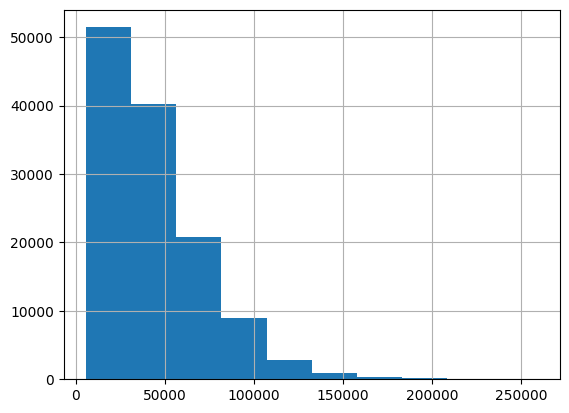

In [68]:
df_sub['price'].hist()

In [69]:
!pip list

Package                            Version
---------------------------------- ---------------------
absl-py                            2.3.1
accelerate                         1.11.0
aiofiles                           25.1.0
aiohappyeyeballs                   2.6.1
aiohttp                            3.13.2
aiosignal                          1.4.0
alembic                            1.4.3
altair                             6.0.0
annotated-types                    0.7.0
anyio                              4.11.0
array_record                       0.8.3
astroid                            4.0.1
asttokens                          3.0.0
astunparse                         1.6.3
async-generator                    1.10
attrs                              25.4.0
autoflake                          2.3.1
autopep8                           2.3.2
banal                              1.0.6
blinker                            1.9.0
cachetools                         6.2.2
catboost                           

In [70]:
!pip show dython


Name: dython
Version: 0.7.11
Summary: A set of data tools in Python
Home-page: http://shakedzy.xyz/dython
Author: Shaked Zychlinski
Author-email: shakedzy@gmail.com
License: MIT
Location: /home/hovar/anaconda3/envs/specbench/lib/python3.12/site-packages
Requires: matplotlib, numpy, pandas, psutil, scikit-learn, scipy, seaborn
Required-by: 


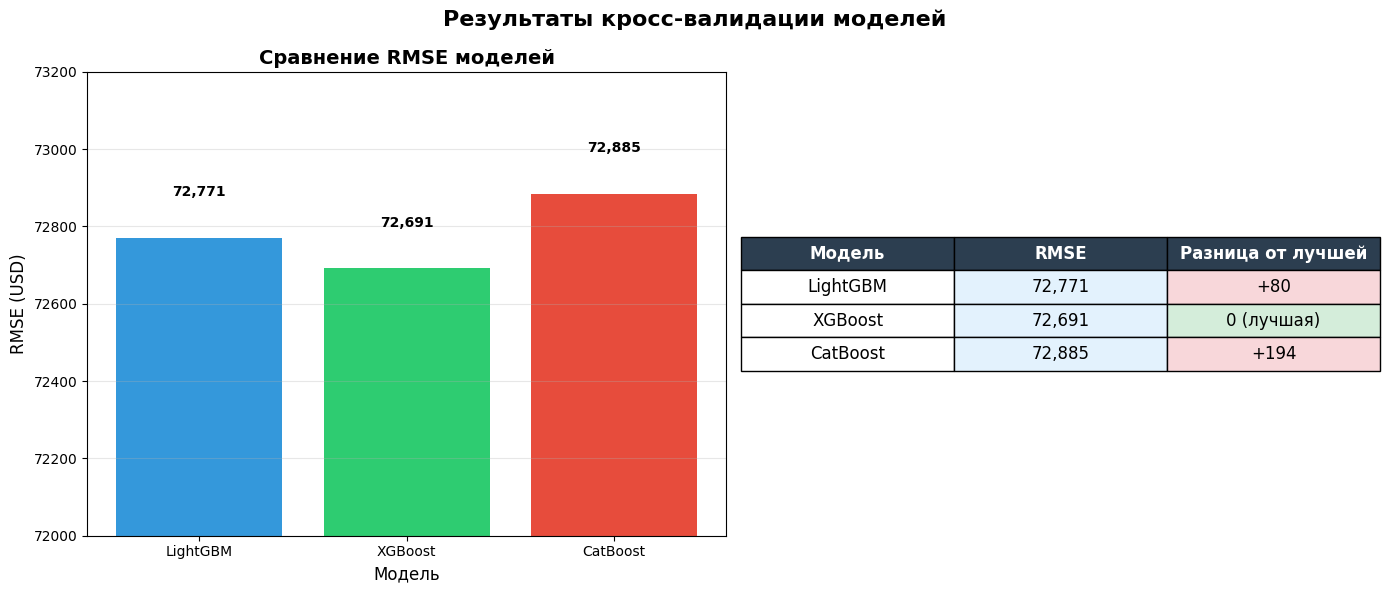


СРАВНЕНИЕ RMSE МОДЕЛЕЙ

Модель          RMSE         Разница от лучшей    % от лучшей
------------------------------------------------------------
LightGBM            72,771        +80 (+0.11%)
XGBoost             72,691         +0 (+0.00%)
CatBoost            72,885       +193 (+0.27%)
------------------------------------------------------------
Среднее             72,782
Лучшая                  XGBoost

ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:
1. Все модели показывают схожие результаты (разница < 0.3%)
2. XGBoost немного лучше других (разница всего 80-194 USD)
3. Качество достаточно стабильное для ансамблирования
4. Средняя ошибка предсказания: ~$73,000


In [2]:
import matplotlib.pyplot as plt
import numpy as np

rmse_values = {
    'LightGBM': 72771.25,
    'XGBoost': 72691.49,
    'CatBoost': 72884.58
}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

models = list(rmse_values.keys())
rmse_scores = list(rmse_values.values())

bars = ax1.bar(models, rmse_scores, color=['#3498db', '#2ecc71', '#e74c3c'])
ax1.set_title('Сравнение RMSE моделей', fontsize=14, fontweight='bold')
ax1.set_xlabel('Модель', fontsize=12)
ax1.set_ylabel('RMSE (USD)', fontsize=12)
ax1.set_ylim(72000, 73200)
ax1.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, rmse_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'{score:,.0f}', ha='center', va='bottom', fontweight='bold')

ax2.axis('off')  

# Создаем таблицу
table_data = [
    ['Модель', 'RMSE', 'Разница от лучшей'],
    ['LightGBM', '72,771', '+80'],
    ['XGBoost', '72,691', '0 (лучшая)'],
    ['CatBoost', '72,885', '+194']
]

# Создаем таблицу
table = ax2.table(cellText=table_data, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

# Стилизация ячеек таблицы
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Заголовок
        cell.set_facecolor('#2c3e50')
        cell.set_text_props(color='white', weight='bold')
    else:
        if j == 2:  # Столбец с разницей
            if '+' in cell.get_text().get_text():
                cell.set_facecolor('#f8d7da')  # Красный для худших
            else:
                cell.set_facecolor('#d4edda')  # Зеленый для лучшей
        elif j == 1:  # Столбец с RMSE
            cell.set_facecolor('#e3f2fd')  # Голубой для значений RMSE

# Вычисляем статистику
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)
best_model = min(rmse_values, key=rmse_values.get)
best_score = min(rmse_scores)




plt.suptitle('Результаты кросс-валидации моделей', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Вывод в консоль
print("\n" + "="*60)
print("СРАВНЕНИЕ RMSE МОДЕЛЕЙ")
print("="*60)

print(f"\n{'Модель':<15} {'RMSE':<12} {'Разница от лучшей':<20} {'% от лучшей':<10}")
print("-"*60)

for model, score in rmse_values.items():
    diff = score - best_score
    percent_diff = (diff / best_score) * 100
    print(f"{model:<15} {score:>10,.0f} {diff:>+10,.0f} ({percent_diff:>+5.2f}%)")

print("-"*60)
print(f"{'Среднее':<15} {mean_rmse:>10,.0f}")
print(f"{'Лучшая':<15} {best_model:>15}")

print("\n" + "="*60)
print("ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ:")
print("="*60)
print("1. Все модели показывают схожие результаты (разница < 0.3%)")
print("2. XGBoost немного лучше других (разница всего 80-194 USD)")
print("3. Качество достаточно стабильное для ансамблирования")
print("4. Средняя ошибка предсказания: ~$73,000")